In [1]:
import nibabel as nib
from nilearn.image import resample_to_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

subs = [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27]
stim_intensities = [55, 47, 56, 63, 60, 53, 54, 55, 60, 44, 46, 58, 47, 55, 50, 53, 50, 48, 50, 50]
stim_dIdt = [round((a / 60) * 87 *1e6) for a in stim_intensities]
masterpath = "/d/DATC/datc/MD_TMS_EEG/SIMNIBS_output/"

In [2]:
# Read csv file containing coil location information
metadatapath = '/d/DATC/datc/MD_TMS_EEG/analysis/EEG_TMS_meta - Summary.csv' 
df = pd.read_csv(metadatapath)
hemisphere_values = df['Hemisphere stimulated'].values
print(hemisphere_values)


['Left' 'Left' 'Right' 'Right' 'Left' 'Right' 'Left' 'Right' 'Right'
 'Right' 'Left' 'Left' 'Left' 'Right' 'Right' 'Left' 'Left' 'Right' nan
 nan 'Right' 'Right' 'Right' 'Left' 'Right' 'Left' 'Left' nan nan]


In [3]:
# Function to load nifty
def load_nii_file(fpath, T1):
    nii_img = nib.load(fpath)
    if nii_img.shape[0] != 320:
        nii_img = resample_to_img(fpath, T1, interpolation='nearest')
    data = nii_img.get_fdata()
    
    return data

# Function to compute average from mask
def calculate_average_over_mask(whole_brain, mask):
    masked_data = whole_brain[mask > 0]
    #print(masked_data.shape)
    average_value = masked_data.mean() 
    #########print(average_value)
    return average_value

In [4]:
data = {}
meanarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
for idx in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]:
    sub = subs[idx]
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_values[sub-1]
    # print(this_hemi, sub)
    # print(this_hemi == 'Left')

    subfoldpath = f"{masterpath}{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simulation/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }

    data[sub_id] = {metric_name: load_nii_file(path, file_paths['T1'])
                    for metric_name, path in file_paths.items()}
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    
    for roi_name, path in file_paths.items():
        roi_data = load_nii_file(path, f"{subfoldpath}/T1.nii")
        mean_value = calculate_average_over_mask(metric_data, roi_data)
        meanarray[roi_name].append(mean_value)

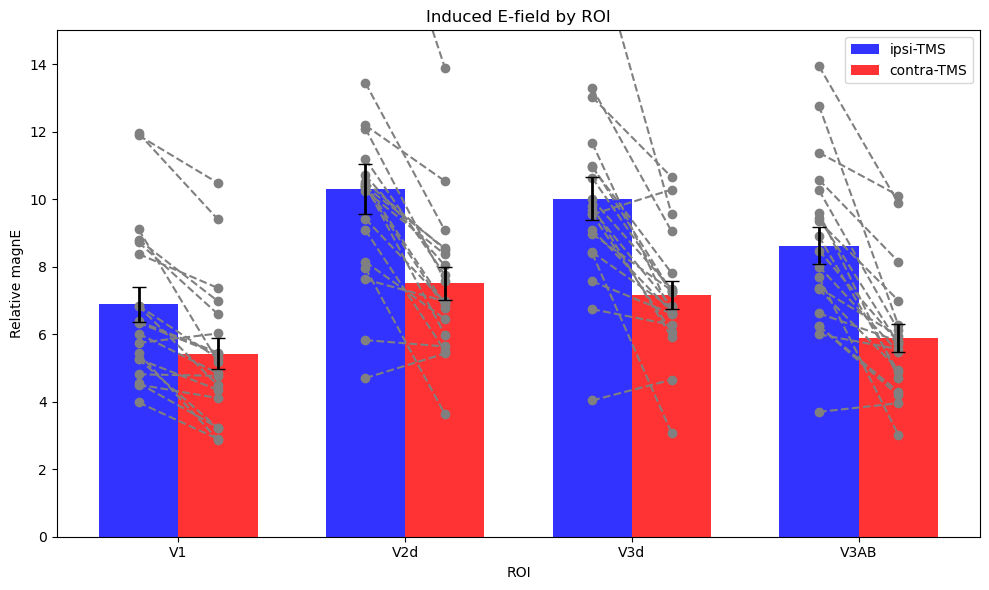

In [11]:
means = {roi: np.mean(values) for roi, values in meanarray.items()}
std_errors = {roi: np.std(values) / np.sqrt(len(values)) for roi, values in meanarray.items()}
roi_list = ['V1', 'V2d', 'V3d', 'V3AB']

fig, ax = plt.subplots(figsize=(10, 6))

n_groups = len(means) // 2
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

for i, roi in enumerate(roi_list):
    lh_mean = meanarray[f'lh{roi}']
    rh_mean = meanarray[f'rh{roi}']
    lh_x = index[i] - bar_width/2
    rh_x = lh_x + bar_width
    ax.plot([lh_x + bar_width/2, rh_x + bar_width/2], [lh_mean, rh_mean], 'grey', linestyle='--', marker='o')


left_bars = ax.bar(index, [means[f'lh{roi}'] for roi in roi_list],
                   bar_width, alpha=opacity, color='b',
                   yerr=[std_errors[f'lh{roi}'] for roi in roi_list],
                   label='ipsi-TMS', error_kw={'elinewidth':2, 'capsize':5})

right_bars = ax.bar(index + bar_width, [means[f'rh{roi}'] for roi in roi_list],
                    bar_width, alpha=opacity, color='r',
                    yerr=[std_errors[f'rh{roi}'] for roi in roi_list],
                    label='contra-TMS', error_kw={'elinewidth':2, 'capsize':5})

ax.set_xlabel('ROI')
ax.set_ylabel('Relative magnE')
ax.set_title('Induced E-field by ROI')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(roi_list)
ax.legend()

# Adding a grid, setting the limit and making layout tight
#ax.yaxis.grid(True)
ax.set_ylim([0, max(means.values()) + max(std_errors.values()) * 3])  # Adjust the y-axis limit to show error bars
plt.tight_layout()
plt.ylim([0, 15])
# Show the plot
plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/efield_induced.eps', format = 'eps', dpi = 1200)
plt.show()


In [8]:
np.mean(meanarray['T1'])

1.5370177975194674

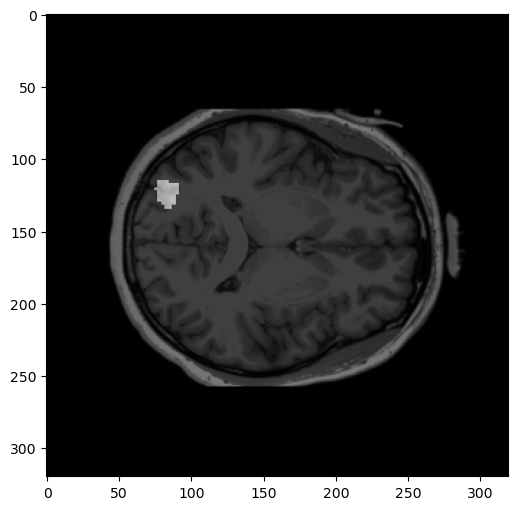

In [20]:
slcnum = 140
plt.figure(figsize=(10, 6))
plt.imshow(data['sub03']['T1'][:, slcnum, :], cmap='gray')
#plt.imshow(data['sub01']['lhV1'][:, slcnum, :], cmap = 'gray', alpha = 0.5)
plt.imshow(data['sub03']['lhV3AB'][:, slcnum, :], cmap = 'gray', alpha = 0.5)

plt.show()